<h1 style="text-align: center;">RNN MODEL WITH MACD TRIGGER</h1>

<h2>Initialization</h2>

In [2]:
# Libraries
import MetaTrader5 as mt5  # pip install MetaTrader5
import pandas as pd  # pip install pandas
import talib
import numpy as np
from datetime import datetime
import plotly.express as px  # pip install plotly

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

In [3]:
# start the platform with initialize()
mt5.initialize()

True

In [4]:
# login to Trade Account with login()
# make sure that trade server is enabled in MT5 client terminal

login = 5044174558
password = '-a6bNxSy'
server = 'MetaQuotes-Demo'

mt5.login(login, password, server)

True

In [5]:
# get account info
account_info = mt5.account_info()
print(account_info)

# getting specific account data
login_number = account_info.login
balance = account_info.balance
equity = account_info.equity

print()
print('login: ', login_number)
print('balance: ', balance)
print('equity: ', equity)

AccountInfo(login=5044174558, trade_mode=0, leverage=100, limit_orders=200, margin_so_mode=0, trade_allowed=True, trade_expert=True, margin_mode=2, currency_digits=2, fifo_close=False, balance=1000.0, credit=0.0, profit=0.0, equity=1000.0, margin=0.0, margin_free=1000.0, margin_level=0.0, margin_so_call=50.0, margin_so_so=30.0, margin_initial=0.0, margin_maintenance=0.0, assets=0.0, liabilities=0.0, commission_blocked=0.0, name='Jean-Charles Jacques', server='MetaQuotes-Demo', currency='EUR', company='MetaQuotes Ltd.')

login:  5044174558
balance:  1000.0
equity:  1000.0


<h2>GET MARKET DATA</h2>

In [6]:
symbol = "EURUSD"
info = mt5.symbol_info(symbol)

point = info.point       # ex: 0.00001
digits = info.digits     # ex: 5

pip_value = point * 10   # 1 pip en valeur de prix


In [7]:
timeframe = mt5.TIMEFRAME_M5
start_pos = 0
num_bars = 10000

In [8]:
def timeframe_to_str(tf):
    mapping = {
        mt5.TIMEFRAME_M1: "M1",
        mt5.TIMEFRAME_M5: "M5",
        mt5.TIMEFRAME_M15: "M15",
        mt5.TIMEFRAME_M30: "M30",
        mt5.TIMEFRAME_H1: "H1",
        mt5.TIMEFRAME_H4: "H4",
        mt5.TIMEFRAME_D1: "D1",
    }
    return mapping.get(tf, "UNKNOWN")

print(timeframe_to_str(timeframe))

M5


In [ ]:
# ohlc_data
ohlc_data = pd.DataFrame(mt5.copy_rates_from_pos(symbol, timeframe, start_pos, num_bars))

fig = px.line(ohlc_data, x=ohlc_data['time'], y=ohlc_data['close'])
fig.show()

ohlc_data

In [ ]:
ohlc_data.to_csv(f'data/{symbol}_{timeframe_to_str(timeframe)}.csv')

<h2>COMMON FUNCTIONS</h2>

In [9]:
def plot_loss(history, title="Model Loss Over Epochs"):
    loss_df = pd.DataFrame({
        "Epoch": range(1, len(history.history["loss"]) + 1),
        "Train Loss": history.history["loss"],
        "Validation Loss": history.history.get("val_loss")
    })

    fig = px.line(
        loss_df,
        x="Epoch",
        y=["Train Loss", "Validation Loss"],
        title=title,
        labels={"value": "Loss", "variable": "Metric"}
    )

    fig.update_layout(
        hovermode="x unified",
        template="plotly_white"
    )

    fig.show()

<h2>TRAIN MODEL</h2>

In [10]:
# Charger le dataset
df = pd.read_csv(f'data/{symbol}_{timeframe_to_str(timeframe)}.csv')
df = df[['close', 'high', 'low', 'tick_volume']].dropna()

In [11]:
# Calcul du MACD
macd, macd_signal, macd_hist = talib.MACD(
    df["close"].values,
    fastperiod=12,
    slowperiod=26,
    signalperiod=9
)

df["macd"] = macd
df["macd_signal"] = macd_signal
df["macd_hist"] = macd_hist


In [12]:
# Calcul du trigger
df["macd_trigger"] = 0

df.loc[
    (df["macd_hist"].shift(1) < 0) & (df["macd_hist"] > 0),
    "macd_trigger"
] = 1   # LONG

df.loc[
    (df["macd_hist"].shift(1) > 0) & (df["macd_hist"] < 0),
    "macd_trigger"
] = -1  # SHORT


In [13]:
features = ["close", "tick_volume", "macd_hist"]
df_model = df[features + ["macd_trigger"]].dropna()

In [14]:
# Normalisation (CRUCIAL pour un RNN)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_model[features])

In [15]:
WINDOW_SIZE = 60
HORIZON_MAX = 5

def create_sequences_on_trigger_variable_exit(df, scaled_data, window, horizon_max=3):
    X, idx_list = [], []

    for i in range(window, len(df) - horizon_max):
        if df["macd_trigger"].iloc[i] == 0:
            continue

        X.append(scaled_data[i-window:i])
        idx_list.append(i)  # POSITION, pas index temporel

    return np.array(X), np.array(idx_list)


In [16]:
X, idx = create_sequences_on_trigger_variable_exit(
    df_model,
    scaled_features,
    WINDOW_SIZE,
    HORIZON_MAX
)

split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
idx_train, idx_test = idx[:split], idx[split:]


In [17]:
def build_hit_labels(
    df_model,
    df_full,
    idx_list,
    horizon_max=3
):
    y_hit = []

    for idx in idx_list:
        macd_trig = df_model.loc[idx, "macd_trigger"]

        if macd_trig == 0:
            y_hit.append(0)
            continue

        entry_price = df_full.loc[idx, "close"]
        entry_loc = df_full.index.get_loc(idx)

        future_prices = df_full.iloc[
            entry_loc + 1 : entry_loc + horizon_max + 1
        ]["close"].values

        if len(future_prices) < horizon_max:
            y_hit.append(0)
            continue

        if macd_trig == 1:
            hit = np.max(future_prices) > entry_price
        else:
            hit = np.min(future_prices) < entry_price

        y_hit.append(int(hit))

    return np.array(y_hit)

In [18]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

y_train_hit = build_hit_labels(
    df_model, df, idx_train, horizon_max=HORIZON_MAX
)

y_test_hit = build_hit_labels(
    df_model, df, idx_test, horizon_max=HORIZON_MAX
)

pos = (y_train_hit == 1).sum()
neg = (y_train_hit == 0).sum()

class_weight = {
    0: pos / (pos + neg),
    1: neg / (pos + neg)
}

print("Class weight:", class_weight)

model = Sequential([
    Input(shape=(WINDOW_SIZE, X_train.shape[2])),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train_hit,
    validation_data=(X_test, y_test_hit),
    epochs=60,
    batch_size=32,
    shuffle=False,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)


Class weight: {0: 0.05801526717557252, 1: 0.9419847328244275}
Epoch 1/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2855 - loss: 0.0753 - val_accuracy: 0.9756 - val_loss: 0.6536 - learning_rate: 0.0010
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5969 - loss: 0.0751 - val_accuracy: 0.9817 - val_loss: 0.5742 - learning_rate: 0.0010
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6947 - loss: 0.0743 - val_accuracy: 0.9817 - val_loss: 0.4985 - learning_rate: 0.0010
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7206 - loss: 0.0735 - val_accuracy: 0.9817 - val_loss: 0.3842 - learning_rate: 0.0010
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6351 - loss: 0.0742 - val_accuracy: 0.9817 - val_loss: 0.3752 - learning_rate: 0.0010
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3206 - loss: 0.0738 - val_accuracy: 0.9817 - val_loss: 0.4023 - learning_rate: 0.0010
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━

In [19]:
plot_loss(history)

<h2>TEST VALIDATION</h2>

In [20]:
def build_trade_df_variable_horizon(
    df_model,
    df_full,
    idx_part,
    hit_proba_part,   # 🔥 sortie du LSTM (0–1)
    horizon_max=3,
    threshold=0.55
):
    trade_rows = []

    for idx, proba in zip(idx_part, hit_proba_part):

        macd_trig = df_model.loc[idx, "macd_trigger"]
        macd_val  = df_full.loc[idx, "macd"]

        # Pas de signal directionnel
        if macd_trig == 0:
            continue

        # Filtre ML (qualité du trade)
        if proba < threshold:
            continue

        # Direction UNIQUEMENT via MACD
        trade = 1 if macd_trig == 1 else -1

        entry_price = df_full.loc[idx, "close"]
        entry_loc = df_full.index.get_loc(idx)

        future_prices = df_full.iloc[
            entry_loc + 1 : entry_loc + horizon_max + 1
        ]["close"].values

        if len(future_prices) < horizon_max:
            continue

        # Évaluation opportuniste
        if trade == 1:
            success = np.max(future_prices) > entry_price
            best_exit = np.max(future_prices)
        else:
            success = np.min(future_prices) < entry_price
            best_exit = np.min(future_prices)

        trade_rows.append({
            "time": idx,
            "close": entry_price,
            "trade": trade,
            "hit": int(success),
            "entry": entry_price,
            "best_exit": best_exit,
            "hit_proba": proba,
            "macd_trigger": macd_trig
        })

    df_trades = pd.DataFrame(trade_rows)

    if df_trades.empty:
        return df_trades

    return df_trades.set_index("time")


In [21]:
import plotly.graph_objects as go

def plot_trades(trade_df, df_full, title=f"MACD + LSTM Trades ({timeframe_to_str(timeframe)})"):
    fig = go.Figure()

    # prix
    fig.add_trace(go.Scatter(
        x=df_full.index,
        y=df_full["close"],
        mode="lines",
        name="Close",
        line=dict(color="black")
    ))

    # LONG
    long_trades = trade_df[trade_df["trade"] == 1]
    fig.add_trace(go.Scatter(
        x=long_trades.index,
        y=long_trades["close"],
        mode="markers",
        name="LONG",
        marker=dict(symbol="triangle-up", size=10, color="green")
    ))

    # SHORT
    short_trades = trade_df[trade_df["trade"] == -1]
    fig.add_trace(go.Scatter(
        x=short_trades.index,
        y=short_trades["close"],
        mode="markers",
        name="SHORT",
        marker=dict(symbol="triangle-down", size=10, color="red")
    ))

    fig.update_layout(
        title=title,
        hovermode="x unified",
        template="plotly_white"
    )

    fig.show()


In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_trades_with_macd(
    trade_df,
    df_full,
    title=f"MACD + LSTM Trades ({timeframe_to_str(timeframe)})"
):
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.08,
        row_heights=[0.65, 0.35],
        subplot_titles=("Price & Trades", "MACD")
    )

    # =====================
    # 1️⃣ PRIX
    # =====================
    fig.add_trace(
        go.Scatter(
            x=df_full.index,
            y=df_full["close"],
            mode="lines",
            name="Close",
            line=dict(color="black", width=1)
        ),
        row=1, col=1
    )

    # LONG
    long_trades = trade_df[trade_df["trade"] == 1]
    fig.add_trace(
        go.Scatter(
            x=long_trades.index,
            y=long_trades["close"],
            mode="markers",
            name="LONG",
            marker=dict(symbol="triangle-up", size=10, color="green")
        ),
        row=1, col=1
    )

    # SHORT
    short_trades = trade_df[trade_df["trade"] == -1]
    fig.add_trace(
        go.Scatter(
            x=short_trades.index,
            y=short_trades["close"],
            mode="markers",
            name="SHORT",
            marker=dict(symbol="triangle-down", size=10, color="red")
        ),
        row=1, col=1
    )

    # =====================
    # 2️⃣ MACD
    # =====================
    fig.add_trace(
        go.Scatter(
            x=df_full.index,
            y=df_full["macd"],
            mode="lines",
            name="MACD",
            line=dict(color="blue")
        ),
        row=2, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_full.index,
            y=df_full["macd_signal"],
            mode="lines",
            name="Signal",
            line=dict(color="orange", dash="dot")
        ),
        row=2, col=1
    )

    # Histogramme MACD
    fig.add_trace(
        go.Bar(
            x=df_full.index,
            y=df_full["macd_hist"],
            name="Histogram",
            marker_color=df_full["macd_hist"].apply(
                lambda x: "green" if x >= 0 else "red"
            ),
            opacity=0.4
        ),
        row=2, col=1
    )

    # =====================
    # LAYOUT
    # =====================
    fig.update_layout(
        title=title,
        hovermode="x unified",
        template="plotly_white",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    fig.show()


In [23]:
def direction_metrics(trade_df):
    """
    trade_df doit contenir :
    - trade        ∈ {-1, +1}
    - trade_result ∈ {-1, +1}
    - hit          ∈ {0, 1}
    """

    metrics = {}

    n_trades = len(trade_df)
    n_ok = trade_df["hit"].sum()
    n_nok = n_trades - n_ok

    metrics["Trades"] = int(n_trades)
    metrics["Direction_OK"] = int(n_ok)
    metrics["Direction_NOK"] = int(n_nok)
    metrics["Accuracy_%"] = float(100 * n_ok / n_trades) if n_trades > 0 else np.nan

    # --- LONG / SHORT breakdown ---
    long_trades = trade_df[trade_df["trade"] == 1]
    short_trades = trade_df[trade_df["trade"] == -1]

    if len(long_trades) > 0:
        metrics["LONG_trades"] = int(len(long_trades))
        metrics["LONG_accuracy_%"] = float(100 * long_trades["hit"].mean())
    else:
        metrics["LONG_trades"] = 0
        metrics["LONG_accuracy_%"] = np.nan

    if len(short_trades) > 0:
        metrics["SHORT_trades"] = int(len(short_trades))
        metrics["SHORT_accuracy_%"] = float(100 * short_trades["hit"].mean())
    else:
        metrics["SHORT_trades"] = 0
        metrics["SHORT_accuracy_%"] = np.nan

    # --- biais directionnel ---
    metrics["LONG_%"] = float(100 * (trade_df["trade"] == 1).mean())
    metrics["SHORT_%"] = float(100 * (trade_df["trade"] == -1).mean())

    return metrics



In [24]:
# === Prédictions ===
hit_proba_test = model.predict(X_test).ravel()

print("Hit proba stats:")
print("min :", hit_proba_test.min())
print("mean:", hit_proba_test.mean())
print("max :", hit_proba_test.max())

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Hit proba stats:
min : 0.21580932
mean: 0.22874014
max : 0.25416052


In [25]:
threshold_ml = 0.55
y_test_pred = (hit_proba_test >= threshold_ml).astype(int)

metrics_ml = {
    "Accuracy": accuracy_score(y_test_hit, y_test_pred),
    "Precision": precision_score(y_test_hit, y_test_pred, zero_division=0),
    "Recall": recall_score(y_test_hit, y_test_pred, zero_division=0),
    "F1": f1_score(y_test_hit, y_test_pred, zero_division=0),
    "ROC_AUC": roc_auc_score(y_test_hit, hit_proba_test)
}

print("📊 ML metrics on TEST:")
for k, v in metrics_ml.items():
    print(f"{k}: {v:.3f}")

📊 ML metrics on TEST:
Accuracy: 0.982
Precision: 0.000
Recall: 0.000
F1: 0.000
ROC_AUC: 0.495


In [26]:
cm = confusion_matrix(y_test_hit, y_test_pred)

print("Confusion matrix:")
print(cm)


Confusion matrix:
[[161   0]
 [  3   0]]


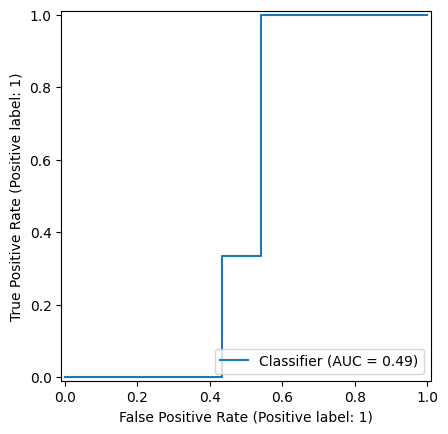

In [27]:
RocCurveDisplay.from_predictions(y_test_hit, hit_proba_test)
plt.show()


In [29]:
def build_trade_df_for_plot(
    df_model,
    df_full,
    idx_part,
    hit_proba_part,
    threshold=0.55
):
    rows = []

    for idx, proba in zip(idx_part, hit_proba_part):

        macd_trig = df_model.loc[idx, "macd_trigger"]

        # pas de signal
        if macd_trig == 0:
            continue

        # filtre ML
        if proba < threshold:
            continue

        trade = 1 if macd_trig == 1 else -1

        rows.append({
            "time": idx,
            "trade": trade,
            "close": df_full.loc[idx, "close"],
            "hit_proba": proba
        })

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).set_index("time")

In [33]:
print("len(idx_test):", len(idx_test))
print("idx_test sample:", idx_test[:5])
print("Index exists in df_model:",
      all(idx in df_model.index for idx in idx_test[:10]))

len(idx_test): 164
idx_test sample: [7861 7865 7895 7921 7934]
Index exists in df_model: True


In [34]:
macd_vals = df_model.loc[idx_test, "macd_trigger"]

print("MACD trigger distribution on TEST:")
print(macd_vals.value_counts(normalize=True))


MACD trigger distribution on TEST:
macd_trigger
 0    0.951220
-1    0.030488
 1    0.018293
Name: proportion, dtype: float64


In [35]:
print("Hit proba stats:")
print("min :", hit_proba_test.min())
print("mean:", hit_proba_test.mean())
print("max :", hit_proba_test.max())

for t in [0.55, 0.5, 0.45, 0.4]:
    print(f"Pct proba >= {t} :", (hit_proba_test >= t).mean())


Hit proba stats:
min : 0.21580932
mean: 0.22874014
max : 0.25416052
Pct proba >= 0.55 : 0.0
Pct proba >= 0.5 : 0.0
Pct proba >= 0.45 : 0.0
Pct proba >= 0.4 : 0.0


<h2>WALK-FORWARD</h2>

In [ ]:
TRAIN_SIZE = 1000   # bougies M5 (~3–4 jours)
TEST_SIZE  = 300    # bougies M5 (~1 jour)
STEP_SIZE  = 300    # on avance d’un test

In [ ]:
def scale_train_test(train_df, test_df, feature_cols):
    """
    Fit le scaler sur TRAIN uniquement,
    puis transforme TRAIN et TEST avec le même scaler.
    """
    scaler = MinMaxScaler()
    
    X_train_scaled = scaler.fit_transform(train_df[feature_cols])
    X_test_scaled  = scaler.transform(test_df[feature_cols])
    
    return X_train_scaled, X_test_scaled


In [ ]:
def walk_forward_backtest(
    df,
    df_model,
    feature_cols,
    window_size,
    horizon_max,
    train_size,
    test_size,
    step_size,
    threshold=0.55
):
    results = []
    start = window_size

    while start + train_size + test_size < len(df_model):

        train_start = start
        train_end   = start + train_size
        test_end    = train_end + test_size

        df_train = df_model.iloc[train_start:train_end]
        df_test  = df_model.iloc[train_end:test_end]

        # === Scaling PROPRE ===
        X_train_scaled, X_test_scaled = scale_train_test(
            df_train, df_test, feature_cols
        )

        # === Séquences (TA fonction existante) ===
        X_train, idx_train = create_sequences_on_trigger_variable_exit(
            df_train,
            X_train_scaled,
            window_size,
            horizon_max
        )

        X_test, idx_test = create_sequences_on_trigger_variable_exit(
            df_test,
            X_test_scaled,
            window_size,
            horizon_max
        )

        if len(X_train) < 50 or len(X_test) < 10:
            start += step_size
            continue

        # === Conversion indices → index temporel réel ===
        idx_train_abs = df_model.index[train_start + idx_train]
        idx_test_abs  = df_model.index[train_end + idx_test]


        # === Labels HIT / NO-HIT ===
        y_train_hit = build_hit_labels(
            df_model=df_model,
            df_full=df,
            idx_list=idx_train_abs,
            horizon_max=horizon_max
        )

        if y_train_hit.sum() < 5:
            start += step_size
            continue

        # === Modèle ===
        model = Sequential([
            Input(shape=(window_size, X_train.shape[2])),
            LSTM(32),
            Dropout(0.3),
            Dense(1, activation="sigmoid")
        ])

        model.compile(
            optimizer="adam",
            loss="binary_crossentropy"
        )

        model.fit(
            X_train, y_train_hit,
            epochs=30,
            batch_size=32,
            shuffle=False,
            verbose=0
        )

        # === Prédictions ===
        hit_proba_test = model.predict(X_test).ravel()

        # === Trades TEST ===
        trade_df_test = build_trade_df_variable_horizon(
            df_model=df_model,
            df_full=df,
            idx_part=idx_test_abs,
            hit_proba_part=hit_proba_test,
            horizon_max=horizon_max,
            threshold=threshold
        )

        if len(trade_df_test) > 0:
            results.append({
                "start_idx": train_start,
                "trades": len(trade_df_test),
                "accuracy": trade_df_test["hit"].mean()
            })

        start += step_size

    return pd.DataFrame(results)

In [ ]:
FEATURE_COLS = ["close", "tick_volume"]

wf_results = walk_forward_backtest(
    df=df,
    df_model=df_model,
    feature_cols=FEATURE_COLS,
    window_size=WINDOW_SIZE,
    horizon_max=HORIZON_MAX,
    train_size=1000,
    test_size=300,
    step_size=300,
    threshold=0.55
)

print(wf_results)

In [ ]:
import plotly.express as px

px.line(
    wf_results,
    y="accuracy",
    title="Walk-forward accuracy over time"
).show()


In [ ]:
weighted_acc = (
    (wf_results["accuracy"] * wf_results["trades"]).sum()
    / wf_results["trades"].sum()
)
print(weighted_acc)

# GRID SEARCH FOR SL/TP CONFIGURATION

In [ ]:
SL_PIPS = [5, 7, 10, 12, 15]
TP_PIPS = [5, 7, 10, 12, 15, 20]

In [ ]:
def simulate_trade_exit(entry, trade, future_prices, sl_pips, tp_pips, pip_value):
    sl_price = entry - trade * sl_pips * pip_value
    tp_price = entry + trade * tp_pips * pip_value

    for price in future_prices:
        if trade == 1:
            if price <= sl_price:
                return -sl_pips
            if price >= tp_price:
                return tp_pips
        else:
            if price >= sl_price:
                return -sl_pips
            if price <= tp_price:
                return tp_pips

    # sortie au dernier prix si rien touché
    return (future_prices[-1] - entry) / pip_value * trade


In [ ]:
def evaluate_sl_tp(trade_df, sl_pips, tp_pips, df_full, horizon, pip_value):
    pnl = []

    for idx, row in trade_df.iterrows():
        entry = row["entry"]
        trade = row["trade"]
        loc = df_full.index.get_loc(idx)

        future_prices = df_full.iloc[loc+1 : loc+horizon+1]["close"].values
        if len(future_prices) == 0:
            continue

        pnl.append(
            simulate_trade_exit(entry, trade, future_prices, sl_pips, tp_pips, pip_value)
        )

    pnl = np.array(pnl)

    return {
        "trades": len(pnl),
        "win_rate": np.mean(pnl > 0),
        "avg_pnl": pnl.mean(),
        "expectancy": pnl.mean(),
        "profit_factor": pnl[pnl>0].sum() / abs(pnl[pnl<0].sum()) if np.any(pnl<0) else np.nan,
        "max_dd": np.min(np.cumsum(pnl))
    }


In [ ]:
results = []

for sl in SL_PIPS:
    for tp in TP_PIPS:
        metrics = evaluate_sl_tp(
            trade_df_test,
            sl, tp,
            df, horizon=3,
            pip_value=0.0001
        )
        metrics.update({"SL": sl, "TP": tp})
        results.append(metrics)

sl_tp_df = pd.DataFrame(results)


In [ ]:
sl_tp_df

In [ ]:
def select_best_sl_tp(
    sl_tp_df,
    min_trades=30,
    max_drawdown=None,
    min_profit_factor=1.2
):
    """
    Sélectionne la meilleure configuration SL / TP
    selon des critères robustes.
    """

    df = sl_tp_df.copy()

    # 1️⃣ Filtrer configurations statistiquement faibles
    df = df[df["trades"] >= min_trades]

    # 2️⃣ Filtrer sur profit factor
    df = df[df["profit_factor"] >= min_profit_factor]

    # 3️⃣ Filtrer sur drawdown si demandé
    if max_drawdown is not None:
        df = df[df["max_dd"] >= -abs(max_drawdown)]

    if len(df) == 0:
        print("⚠️ Aucune configuration robuste trouvée.")
        return None

    # 4️⃣ Score composite (robuste)
    df["score"] = (
        df["expectancy"] *
        df["profit_factor"] /
        abs(df["max_dd"])
    )

    # 5️⃣ Meilleure config
    best = df.sort_values("score", ascending=False).iloc[0]

    return best

In [ ]:
best_sl_tp = select_best_sl_tp(
    sl_tp_df,
    min_trades=30,
    max_drawdown=50,      # pips
    min_profit_factor=1.2
)

print(best_sl_tp)

# EQUITY SIMULATION

In [ ]:
def equity_curve_from_expectancy(
    stats,
    lot=0.1,
    capital_initial=1000,
    pip_value_per_lot=10
):
    """
    stats : dict ou Series contenant
        - trades
        - expectancy (en pips)
    lot : taille de position (ex: 0.1)
    capital_initial : capital de départ en €
    """

    trades = int(stats["trades"])
    expectancy_pips = stats["expectancy"]

    # € gagnés en moyenne par trade
    expectancy_eur = expectancy_pips * lot * pip_value_per_lot

    # série des gains espérés
    pnl_eur = np.full(trades, expectancy_eur)

    equity = capital_initial + np.cumsum(pnl_eur)

    df_equity = pd.DataFrame({
        "trade": np.arange(1, trades + 1),
        "pnl_eur": pnl_eur,
        "equity_eur": equity
    })

    # graphique
    fig = px.line(
        df_equity,
        x="trade",
        y="equity_eur",
        title=(
            f"Évolution du capital (espérée)<br>"
            f"Lot={lot} | Capital initial={capital_initial} € | "
            f"Expectancy={expectancy_pips:.2f} pips"
        ),
        labels={
            "trade": "Trade #",
            "equity_eur": "Capital (€)"
        }
    )

    fig.show()

    return df_equity

In [ ]:
stats = {
    "trades": 46,
    "expectancy": 0.697826,
    "profit_factor": 1.818878,
    "max_dd": -0.9,
    "SL": 15,
    "TP": 15,
    "score": 1.410289
}

df_equity = equity_curve_from_expectancy(
    stats,
    lot=0.1,
    capital_initial=1000
)


In [ ]:
def simulate_exit_price(
    entry_price,
    trade_dir,
    future_prices,
    sl_pips,
    tp_pips,
    pip_value
):
    """
    entry_price : prix d'entrée
    trade_dir   : +1 (long) ou -1 (short)
    future_prices : array des prix close futurs
    sl_pips / tp_pips : SL / TP en pips
    """

    sl_price = entry_price - trade_dir * sl_pips * pip_value
    tp_price = entry_price + trade_dir * tp_pips * pip_value

    for price in future_prices:
        if trade_dir == 1:
            if price <= sl_price:
                return sl_price
            if price >= tp_price:
                return tp_price
        else:
            if price >= sl_price:
                return sl_price
            if price <= tp_price:
                return tp_price

    # si ni SL ni TP touché → sortie au dernier prix
    return future_prices[-1]


def add_exit_and_pnl(
    trade_df,
    df_prices,
    sl_pips,
    tp_pips,
    horizon,
    pip_value=0.0001
):
    trade_df = trade_df.copy()

    exit_prices = []
    pnl_pips = []

    for idx, row in trade_df.iterrows():
        entry = row["entry"]
        trade = row["trade"]

        loc = df_prices.index.get_loc(idx)
        future_prices = df_prices.iloc[
            loc + 1 : loc + horizon + 1
        ]["close"].values

        if len(future_prices) == 0:
            exit_prices.append(np.nan)
            pnl_pips.append(np.nan)
            continue

        exit_price = simulate_exit_price(
            entry,
            trade,
            future_prices,
            sl_pips,
            tp_pips,
            pip_value
        )

        exit_prices.append(exit_price)
        pnl_pips.append(
            (exit_price - entry) / pip_value * trade
        )

    trade_df["exit_price"] = exit_prices
    trade_df["pnl_pips"] = pnl_pips

    return trade_df.dropna()


In [ ]:
SL = 15
TP = 15
HORIZON = 3
PIP_VALUE = 0.0001

trade_df_test = add_exit_and_pnl(
    trade_df=trade_df_test,
    df_prices=df,
    sl_pips=SL,
    tp_pips=TP,
    horizon=HORIZON,
    pip_value=PIP_VALUE
)

In [ ]:
def plot_equity_theoretical_vs_real(
    trade_df_test,
    stats,
    lot=0.1,
    capital_initial=1000,
    pip_value_per_lot=10
):
    if "pnl_pips" not in trade_df_test.columns:
        raise ValueError(
            "La colonne 'pnl_pips' est absente.\n"
            "👉 Tu dois d'abord calculer le PnL réel trade par trade "
            "(après SL/TP)."
        )

    trades = len(trade_df_test)
    expectancy_pips = stats["expectancy"]

    # --- Equity théorique ---
    expectancy_eur = expectancy_pips * lot * pip_value_per_lot
    pnl_theoretical = np.full(trades, expectancy_eur)
    equity_theoretical = capital_initial + np.cumsum(pnl_theoretical)

    # --- Equity réelle ---
    pnl_real_eur = trade_df_test["pnl_pips"] * lot * pip_value_per_lot
    equity_real = capital_initial + pnl_real_eur.cumsum()

    df_plot = pd.DataFrame({
        "Trade": np.arange(1, trades + 1),
        "Equity théorique (€)": equity_theoretical,
        "Equity réelle (€)": equity_real
    })

    fig = px.line(
        df_plot,
        x="Trade",
        y=["Equity théorique (€)", "Equity réelle (€)"],
        title=(
            "Évolution du capital – Théorique vs Réel<br>"
            f"Lot={lot} | Capital initial={capital_initial} €"
        ),
        labels={
            "value": "Capital (€)",
            "Trade": "Trade #"
        }
    )

    fig.show()

    return df_plot


In [ ]:
plot_equity_theoretical_vs_real(
    trade_df_test=trade_df_test,
    stats=stats,
    lot=0.1,
    capital_initial=1000
)


In [ ]:
def trade_duration_from_index(
    trade_df,
    timeframe_minutes
):
    first_idx = trade_df.index.min()
    last_idx  = trade_df.index.max()

    bars = last_idx - first_idx

    duration_minutes = bars * timeframe_minutes
    duration_hours   = duration_minutes / 60
    duration_days    = duration_hours / 24

    return {
        "bars": bars,
        "minutes": duration_minutes,
        "hours": duration_hours,
        "days": duration_days
    }

In [ ]:
duration = trade_duration_from_index(
    trade_df_test,
    timeframe_minutes=5
)

print(duration)


In [ ]:
def add_equity_eur(
    trade_df,
    lot=0.1,
    capital_initial=1000,
    pip_value_per_lot=10
):
    trade_df = trade_df.copy()

    # conversion pips → €
    trade_df["pnl_eur"] = (
        trade_df["pnl_pips"] * lot * pip_value_per_lot
    )

    # equity cumulée
    trade_df["equity_eur"] = (
        capital_initial + trade_df["pnl_eur"].cumsum()
    )

    return trade_df


In [ ]:
trade_df_test = add_equity_eur(
    trade_df_test,
    lot=0.1,
    capital_initial=1000
)

print(trade_df_test[["pnl_pips", "pnl_eur", "equity_eur"]].head())


In [ ]:
def compute_max_drawdown_eur(equity_series):
    """
    equity_series : Series pandas du capital en €
    """
    running_max = equity_series.cummax()
    drawdown = equity_series - running_max
    max_dd = drawdown.min()  # négatif

    return max_dd

In [ ]:
max_dd_eur = compute_max_drawdown_eur(
    trade_df_test["equity_eur"]
)

print(f"Max drawdown : {max_dd_eur:.2f} €")


In [ ]:
def performance_summary(
    capital_initial,
    capital_final,
    duration_days,
    equity_series
):
    cagr = (capital_final / capital_initial)**(365 / duration_days) - 1
    max_dd = compute_max_drawdown_eur(equity_series)

    return {
        "Capital initial (€)": capital_initial,
        "Capital final (€)": capital_final,
        "Durée (jours)": duration_days,
        "CAGR théorique (%)": 100 * cagr,
        "Max drawdown (€)": max_dd,
        "Max drawdown (%)": 100 * max_dd / capital_initial
    }


In [ ]:
summary = performance_summary(
    capital_initial=1000,
    capital_final=trade_df_test["equity_eur"].iloc[-1],
    duration_days=7,
    equity_series=trade_df_test["equity_eur"]
)

for k, v in summary.items():
    print(f"{k}: {v:.2f}")


In [ ]:
def performance_summary_equity(
    equity_series,
    capital_initial=1000,
    duration_days=7,
    annual_days_trading=250
):
    capital_final = float(equity_series.iloc[-1])

    # CAGR calendrier & trading-days
    cagr_365 = (capital_final / capital_initial) ** (365 / duration_days) - 1
    cagr_250 = (capital_final / capital_initial) ** (annual_days_trading / duration_days) - 1

    running_max = equity_series.cummax()
    drawdown = equity_series - running_max
    max_dd_eur = float(drawdown.min())

    return {
        "Capital initial (€)": capital_initial,
        "Capital final (€)": capital_final,
        "Durée (jours)": duration_days,
        "Gain total (€)": capital_final - capital_initial,
        "CAGR calendrier 365j (%)": 100 * cagr_365,
        "CAGR trading 250j (%)": 100 * cagr_250,
        "Max drawdown (€)": max_dd_eur,
        "Max drawdown (%)": 100 * max_dd_eur / capital_initial
    }


In [ ]:
summary = performance_summary_equity(
    equity_series=trade_df_test["equity_eur"],
    capital_initial=1000,
    duration_days=7,
    annual_days_trading=250
)

for k, v in summary.items():
    print(f"{k}: {v:.2f}")


In [ ]:
def label_balance(y, name="y"):
    y = np.asarray(y).ravel()
    print(f"{name}: N={len(y)}")
    print("  mean(y) :", y.mean())
    print("  pct(y>0):", (y>0).mean())
    print("  pct(y<0):", (y<0).mean())
    print("  pct(y==0):", (y==0).mean())

label_balance(y_train, "y_train")
label_balance(y_test,  "y_test")


In [ ]:
pred_proba = model.predict(X_test, batch_size=32).ravel()
print("pred_proba mean:", pred_proba.mean())
print("pct > 0.5:", (pred_proba > 0.5).mean())
print("min/max:", pred_proba.min(), pred_proba.max())


In [ ]:
print("macd_trigger value counts (df_model):")
print(df_model["macd_trigger"].value_counts(dropna=False))

# Si tu as des index test (idx_test) :
# print(df_model.loc[idx_test, "macd_trigger"].value_counts())


In [ ]:
def audit_short_pipeline(trade_df):
    # suppose trade_df contient macd_trigger et model_pred (proba ou score)
    c_total = len(trade_df)
    c_trig_short = (trade_df["macd_trigger"] == -1).sum()
    c_pred_short  = (trade_df["model_pred"] < 0.5).sum()
    c_both        = ((trade_df["macd_trigger"] == -1) & (trade_df["model_pred"] < 0.5)).sum()

    print("Total rows:", c_total)
    print("Short trigger candidates:", c_trig_short)
    print("Pred < 0.5 candidates:", c_pred_short)
    print("Short trigger AND pred<0.5:", c_both)

# audit_short_pipeline(trade_df_test)
